# Школа машинного обучения

### Физтех-Школа Прикладной математики и информатики МФТИ 
### Лаборатория нейронных сетей и глубокого обучения (DeepHackLab)  
дедлайн: 4 апреля 23: 59 (MSK)


## Домашнее задание 2
### Метод k-ближайших соседей 
---


In [2]:
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
import collections
import numpy as np
import sklearn

import scipy.stats as sps

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

**Вопрос:** Почему важно, чтобы в тестовой и обучающей выборке пропорции классов были максимально похожи? В качестве примера рассмотрите Ирисы Фишера: в нём три класса, каждый занимает по трети датасета. Далее мы разделяем выборку в пропорциях 2:1, например, при кросс-валидации с тремя фолдами. Что может пойти не так?

В этом ноутбуке за равенство классов отвечает StratifiedKFold (см. пример ниже, подробнее: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html)

Это необходимо для того, чтобы все классы оказывали равное влияние на классификатор, так как если будет мало объектов одного из классов, то они будут оказывать меньшее влияние и точность классификации упадет.

**Задание 1** Примените kNN к классическому <a href="https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0">набору данных "Ирисы Фишера" </a>. Подберите оптимальное число k c помощью поиска по сетке и кросс-валидации. Постройте график зависимости качества от k. Используйте метрику accuracy.

In [3]:
data = load_iris()

iris_X = data.data
iris_y = data.target

In [4]:
iris_X[:5]

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2]])

In [13]:
# Вы уже умеете пользоваться GridSearchCV (см семинар по knn)

knn=KNeighborsClassifier()
knn_grid = {'n_neighbors': np.arange(1, 20)}
gscv = GridSearchCV(knn, knn_grid, cv=10)

gscv.fit(iris_X, iris_y)
print(gscv.best_params_, gscv.best_score_)



{'n_neighbors': 13} 0.98


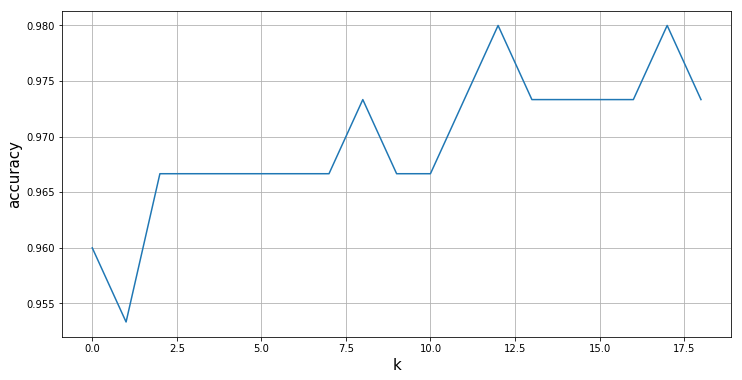

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(gscv.cv_results_["mean_test_score"])
plt.xlabel("k", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.grid()
plt.show()




Если вы смотрели в данные, то вы видели, что признаки примерно одного порядка, т.к. это длины и ширины в сантиметрах. Предположим теперь, что один из признаков измерялся в десятых долях миллиметра. Точно так же подберите оптимальное k для новых данных, сравните качество и постройте график. Что нужно делать, чтобы такая проблема не возникала?

Из-за слишком маленьких размерностей расстояние между объектами на графике уменьшается, а значит точность классификации падает

Можно применить масштабирование признаков и привести их к похожим интервалам, например, с помощью среднего и стандартного отклонения значения признака по всей выборке, использовав функцию scale

In [32]:
X_new = iris_X * np.array((100, 1, 1, 1))
X_new[:5]

array([[5.1e+02, 3.5e+00, 1.4e+00, 2.0e-01],
       [4.9e+02, 3.0e+00, 1.4e+00, 2.0e-01],
       [4.7e+02, 3.2e+00, 1.3e+00, 2.0e-01],
       [4.6e+02, 3.1e+00, 1.5e+00, 2.0e-01],
       [5.0e+02, 3.6e+00, 1.4e+00, 2.0e-01]])

In [33]:
knn=KNeighborsClassifier()
knn_grid = {'n_neighbors':np.arange(1,20)}
gs = GridSearchCV(knn, knn_grid, cv=10)                                 

gs.fit(X_new, iris_y)
print(gs.best_params_, gs.best_score_)


{'n_neighbors': 1} 0.82


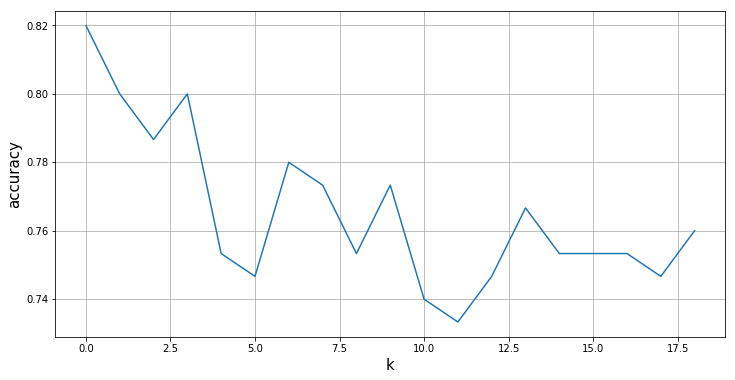

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(gs.cv_results_["mean_test_score"])
plt.xlabel("k", fontsize=15)
plt.ylabel("accuracy", fontsize=15)
plt.grid()
plt.show()




Наглядное отображение проблемы

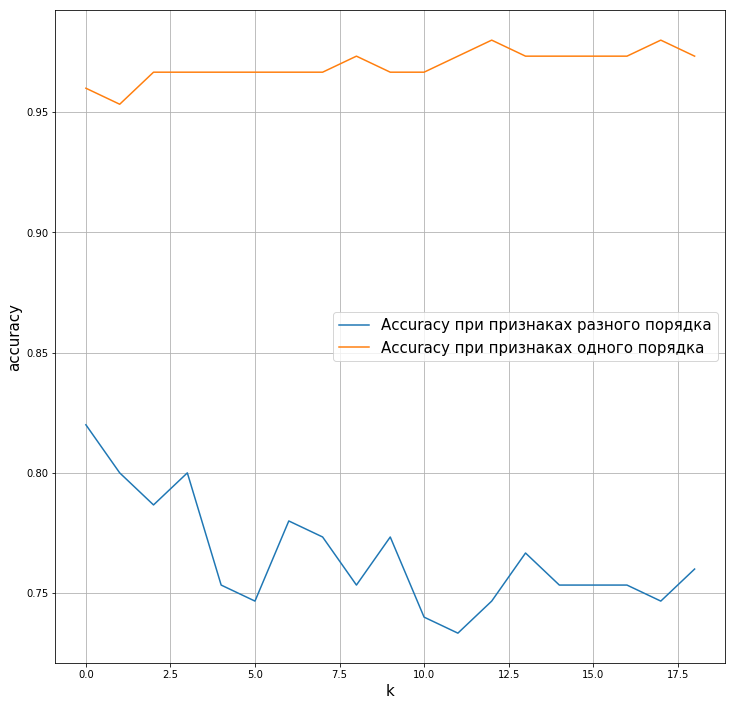

In [43]:
plt.figure(figsize=(12, 12))
plt.plot(gs.cv_results_["mean_test_score"] ,label='Accuracy при признаках разного порядка')
plt.xlabel("k", fontsize=15)
plt.ylabel("accuracy", fontsize=15)

plt.plot(gscv.cv_results_["mean_test_score"] ,label='Accuracy при признаках одного порядка')
plt.legend(fontsize=15)
plt.grid()
plt.show()



**Задание 2:** Реализуйте kNN. Cравните скорости работы реализации с distance_slow,  distance_fast c реализацией из sklearn. Проверьте, что качество такое же. 
Считать, что интерфейс fit и predict такой же, как у KNeighborsClassifier из sklearn

In [60]:
def distance_slow(v, a_list):
    """
    Функция, по вектору v и спиcку векторов a
    находящая попарные расстояния v <-> a[i]
    и возвращающая их как numpy.ndarray той же длины,
    что и список a
    (Работает медленно)
    """
    result = []
    for i in range(a_list.shape[0]):
        length = 0.
        for j in range(a_list.shape[1]):
            length += (v[j] - a_list[i, j]) ** 2
        result.append(length)
    return np.array(result)

In [61]:
def distance_fast(v, a_list):
  
    return np.sum((v-a_list)**2, axis=1)

In [84]:
class kNNClassifier:
    def __init__(self, k=3, distance = distance_slow):
        """
        Parameters
        ----------
        k: int
            Число соседей

        distance: *alias
            функция, по вектору v и спиcку векторов a
            находящая попарные расстояния v <-> a[i]
            и возвращающая их как numpy.ndarray той же длины,
            что и список a
        """
        self._k = k
        self._distance = distance
    
    def fit(self, X_train, y_train):
        self._X = np.copy(X_train)  # Копируем данных, чтобы они не перезаписывались извне
        self._y = np.copy(y_train)
        return self
        
    def predict(self, X_test):
        X_test = np.array(X_test)
        predictions = []
        objects_count = X_test.shape[0]
        for i in range(objects_count):
            pairwise_distances = self._distance(X_test[i], self._X)
            
            k_nearest = self._y[np.argsort(pairwise_distances)[:self._k]]  # нашли k ближайших.
            
            unique_values, counts = np.unique(k_nearest, return_counts=True)
                    
            # Если вы что-то не понимаете - у numpy замечательная документация       
                
            prediction = unique_values[np.argmax(counts)]
            # Предсказываем класс, представителей которого больше всего
            
            predictions.append(prediction) 
            
        return predictions
    
    def get_params(self, deep=False):
        """
        Функция, необходимая для работы GridSearchCV
        Возвращает параметры данного экземпляра класса
        """
        return {
            "k": self._k,
            "distance": self._distance
        }
    
    def set_params(self, **params):
        """
        Функция, необходимая для работы GridSearchCV
        Устанавливает параметры из params 
        (В данном случае пересоздаёт экземпляр класса 
        и возвращает его)
        """
        self.__init__(**params)
        return self

In [85]:
data = load_iris()
X = data.data
y = data.target

clf = KNeighborsClassifier(n_neighbors=3)
print(sklearn.model_selection.cross_val_score(clf, X, y, cv=StratifiedKFold(shuffle = False), scoring="accuracy", ))

[0.98039216 0.96078431 1.        ]


In [93]:
%%time
clf = kNNClassifier()
params = {
    "k":[1, 3, 5, 7, 9, 11, 13, 15, 17],
    "distance":[distance_slow]
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=5), scoring="accuracy", )
gscv.fit(iris_X, iris_y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'distance': <function distance_slow at 0x7faa46db4d08>, 'k': 7}. Best score: 0.98
CPU times: user 2.56 s, sys: 0 ns, total: 2.56 s
Wall time: 2.56 s


In [92]:
%%time
clf = kNNClassifier()
params = {
    "k":[1, 3, 5, 7, 9, 11, 13, 15, 17],
    "distance":[distance_fast]
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=5), scoring="accuracy", )
gscv.fit(iris_X, iris_y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'distance': <function distance_fast at 0x7faa46d626a8>, 'k': 7}. Best score: 0.98
CPU times: user 350 ms, sys: 461 µs, total: 350 ms
Wall time: 350 ms


In [91]:
%%time
clf = KNeighborsClassifier(params)
params = {
    "n_neighbors":[1, 3, 5, 7, 9, 11, 13, 15, 17]
}
gscv = GridSearchCV(clf, params, cv=StratifiedKFold(shuffle = False, n_splits=15), scoring="accuracy", )
gscv.fit(iris_X, iris_y)
print("Best params: {}. Best score: {}".format(gscv.best_params_, gscv.best_score_))

Best params: {'n_neighbors': 13}. Best score: 0.98
CPU times: user 297 ms, sys: 3.21 ms, total: 300 ms
Wall time: 300 ms


distance_fast работает приблизительно в восемь раз быстрее distance_slow

**Комментарий:** Интересующиеся могут изучить <a href="https://habrahabr.ru/post/312882/">kd-tree</a>, позволяющее рассматривать меньшее число расстояний. Так же эта структура используется для отрисовки компьютерной графики.

**Задача 3:** Пусть в данных предыдущей задачи мы получили измерения только двух признаков. Тогда признаки одного обьекта можно представить как точку на плоскости, которой в соответствие поставлен некоторый класс (можно визуализировать это как цвет). Постройте графики, изображающие принадлежность всех точек плоскости к классам для различных k.

In [97]:
data = load_iris()
X = data.data[:, [False, True, True, False]]
y = data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=17)


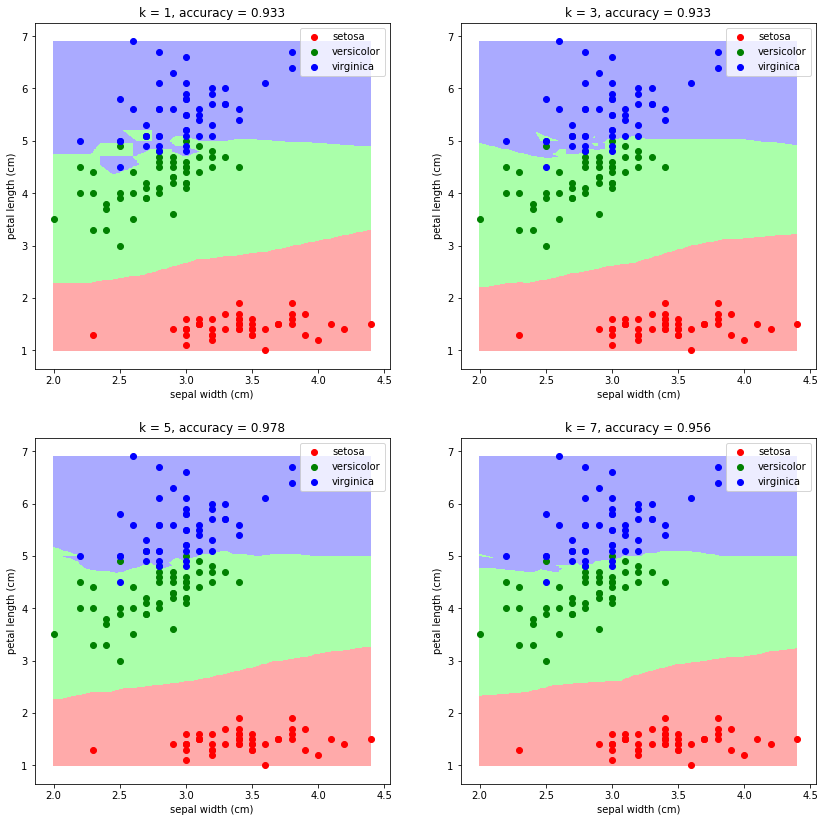

In [101]:
cmap = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
plt.figure(figsize=(14, 14))
for i, k in enumerate([1, 3, 5, 7]):
    plt.subplot(221 + i)

    h = 400
    xx, yy = np.meshgrid(
        np.linspace(X[:, 0].min(), X[:, 0].max(), h),
        np.linspace(X[:, 1].min(), X[:, 1].max(), h)
    )
    
    X_grid = np.c_[xx.ravel(), yy.ravel()]
        
   
    # http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    Z  = knn.predict(X_grid)
    
    z = knn.predict(X_test)
    acc=accuracy_score(y_test, z)
    
    
    plt.title("k = {}, accuracy = {}".format(k, round(acc, 3)))
    zz = np.array(Z).reshape(xx.shape)
   
    # Вызовите plt.pcolormesh для точек xx, yy, zz и цветовой схемы cmap
    # https://matplotlib.org/api/_as_gen/matplotlib.axes.Axes.pcolormesh.html
    plt.pcolormesh(xx, yy, zz, cmap=cmap)
    plt.xlabel(data["feature_names"][1])
    plt.ylabel(data["feature_names"][2])
    for i in range(3):
        plt.scatter(X[y == i, 0], X[y == i, 1], color=["red", "green", "blue"][i], label=data["target_names"][i])
    plt.legend()

plt.show()

Как меняется форма разделяющей кривой при увеличении k и как это сказывается на тестовом качестве? Не забывайте, что иногда в данных встречаются недостоверные измерения, вызванные множеством факторов, например, проблемами при переводе данных из одного формата в другой, в том числе при занесении непосредственных измерений в компьютер.

При увеличении K разделяющая кривая сглаживается, что сказывается негативно на итоговом качестве, так как риск попадания точек, лежащиих около разделяющей кривой, в несоответствующую им область увеличивается. Малое К делает кривую очень резкой и алгоритм начинает очень сильно реагировать на случайные выбросы.

**Задание 4*:** Предлагается датасет, состоящий из писем на две тематики. Задача - научиться классифицировать письма по темам.

In [73]:
categories = [
    'rec.autos',  # тем больше, чем две. Попробуйте другие.)
    'sci.space'#,
    #'sci.med',
    #'sci.electronics'
]

dataset = fetch_20newsgroups(subset='all', categories=categories,
                             shuffle=True, random_state=42)

X = dataset.data
y = dataset.target

In [74]:
len(X), len(y), y

(1977, 1977, array([1, 0, 0, ..., 0, 1, 0]))

Рассмотрим два письма из выборки

In [75]:
print(X[-2])  # Класс 1

From: prb@access.digex.net (Pat)
Subject: Re: HST Servicing Mission Scheduled for 11 Days
Organization: Express Access Online Communications USA
Lines: 14
NNTP-Posting-Host: access.digex.net

In article <C6A2At.E9z@zoo.toronto.edu> henry@zoo.toronto.edu (Henry Spencer) writes:
>
>No, the thing is designed to be retrievable, in a pinch.  Indeed, this
>dictated a rather odd design for the solar arrays, since they had to be
>retractable as well as extendable, and may thus have indirectly contributed
>to the array-flapping problems.


Why not design the solar arrays to be detachable.  if the shuttle is going
to retunr the HST,  what bother are some arrays.  just fit them with a quick release.

one  space walk,  or use the second canadarm to remove the arrays.

pat



In [76]:
print(X[2])  # Класс 0

From: aas7@po.CWRU.Edu (Andrew A. Spencer)
Subject: Re: MR2 - noisy engine.
Organization: Case Western Reserve University, Cleveland, OH (USA)
Lines: 33
Reply-To: aas7@po.CWRU.Edu (Andrew A. Spencer)
NNTP-Posting-Host: slc5.ins.cwru.edu


In a previous article, eliot@lanmola.engr.washington.edu (eliot) says:

>In article <1r1vofINN871@usenet.pa.dec.com> tomacj@opco.enet.dec.com (THUNDERBIRDS ARE GO !!!) writes:
>>	Are there any MR2 owners or motor-head gurus out there, that know why
>>my MR2's engine sounds noisy? The MR2's engine is noisy at the best of times, 
>>but not even a nice nose - it's one of those very ugly noises. 
>
>assuming yours is a non turbo MR2, the gruffness is characteristic of
>a large inline 4 that doesn't have balance shafts.  i guess toyota
>didn't care about "little" details like that when they can brag about
>the mid engine configuration and the flashy styling.
>
>myself, i automatically cross out any car from consideration (or
>recommendation) which has an i

В целом, после прочтения понятно, что первое письмо про космос а второе - про машины. Для того, чтобы классифицировать тексты, нужно перевести их в удобный для алгоритма вид, т.е. сделать из письма вектор. 
Прделагается делать это так: составить список всех используемых слов. Зафиксировать число N самых популярных слов, которые мы будет рассматривать. Каждому письму сопоставлять вектор длины N следующего вида: в a[i] записано число вхождений i-го по популярности слова. Данную задачу решает CountVectoizer: используя его преобразуйте тексты в векторы и подсчитайте качество (accuracy) на классификации.

In [77]:
vect = CountVectorizer(max_features=50)
vect.fit(X)
Xt = vect.transform(X)

In [78]:
# Проверьте качество kNN на данных Xt, y.  Метрика - accuracy
knn = KNeighborsClassifier()

x_train, x_test, y_train, y_test = train_test_split(Xt, y, test_size=0.33, random_state = 42)
knn.fit(x_train, y_train)

result = knn.predict(x_test)

accuracy_score(y_test, result)

0.7289433384379785

Очевидна проблема: самые часто встречающиеся слова встречаются одинаково часто во всех текстах: это a, the, и прочие.
Для этой проблемы также существует стандартное решение: Проверьте качество теперь:

In [79]:
# Создайте экземпляр CountVectorizer с параметрами max_features=50, stop_words="english"
# Как в примере выше, преобразуйте X в Xt

vect = CountVectorizer(max_features=50, stop_words='english')
vect.fit(X)
Xt = vect.transform(X)

In [80]:
# Проверьте качество kNN на данных Xt, y.  Метрика - accuracy
knn = KNeighborsClassifier()

x_train, x_test, y_train, y_test = train_test_split(Xt, y, test_size=0.33, random_state = 42)
knn.fit(x_train, y_train)

result = knn.predict(x_test)
accuracy_score(y_test, result)

0.8330781010719756

Нетрудно догадаться, какие слова будут самыми популярными:

In [81]:
vect.transform(["cake space space car car car"]).toarray()

array([[0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0]])

Качество метрических алгоритмов очень сильно зависит от метрики (функции расстояния). Сравните качество метрик "minkowski" и "cosine" - последняя считает величину, численно равную единице минут косинус угла между векторами, что более уместно для текстов, что обычная евклидова метрика (metric="minkowski", p=2). Найдите параметры, на которых достигается лучшее качество.

In [82]:
params = {
    "n_neighbors": range(1, 15, 2), 
    "metric": ["minkowski", "cosine"]
}

# Вы знаете, что делать.)

При большом числе признаков метрические алгоритмы обычно плохо работают, подробнее: <a href="https://en.wikipedia.org/wiki/Curse_of_dimensionality">проклятие размерности </a>.

In [83]:
knn=KNeighborsClassifier()
gs = GridSearchCV(knn,params, cv=10)

gs.fit(Xt,y)
print(gs.best_params_, gs.best_score_)


{'n_neighbors': 5, 'metric': 'cosine'} 0.885179564997471
